# This notebook creates additional plots currently not used in the poster

Example membrane dynamics

Raster plots

Single neuron activity

Membrane potential distribution of single population


In [1]:
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.axislines import Subplot
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import style as style; reload(style)
import helper_functions as hf; reload(hf)

# Import specific moduls
import model_class; reload(model_class)

%matplotlib inline

save_fig = style.save_fig
figure_path = style.figure_path

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)
colors = style.colors

model = model_class.model()    
label_populations = hf.rlbl(model.populations)

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3.py:215: Warning: Source ID 6 was not found when attempting to remove it
  GLib.source_remove(self._idle_event_id)


## solve_model: requirement for all mean field predictions

In [ ]:
def solve_model(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               jacobian=False, root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root

    if jacobian==False:
        jac = False
    else:
        print("Use jacobian")
        jac = model.jacobian
        
    # Run on initial guess v_guess_0
    sol = root(model.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    if sol["success"]:
        v0  = sol["x"]
        if np.all(v0 < 1./model.t_ref): 
            return v0
        else:       # converged unphysically (v0 >= 1/t_ref)
            raise Exception("Converged unphysically for v_guess_0")
    else:   
        raise Exception("No solution found for v_guess_0")

## Example of membrane dynamics

save figure to single_membrane_potential
save figure to single_membrane_potential_distribution


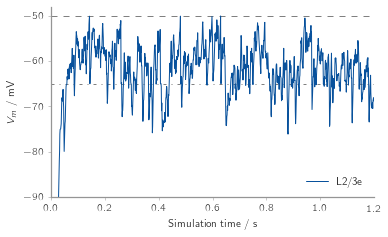

In [67]:
# DATA
sim_spec = "membrane_potential"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)


with h5py.File(path_res_file, "r") as res_file:
    res_grp = res_file["0"]
    
    dset_times_volt     = res_grp["times_volt"]
    times_volt = dset_times_volt[:]
    t_min_volt = dset_times_volt.attrs["t_min_volt"]
    t_max_volt = dset_times_volt.attrs["t_max_volt"]
    dt_volt    = dset_times_volt.attrs["dt_volt"]
    
    volt_plot         = res_grp["volt_plot"][:]
    volt_histo_single = res_grp["volt_histo_single"][:]
    volt_histo_means  = res_grp["volt_histo_means"][:]
    n_hist_max  = res_grp.attrs["n_hist_max"]
    V_min       = res_grp.attrs["V_min"]
    V_max       = res_grp.attrs["V_max"]
    n_bins_volt = res_grp.attrs["n_bins_volt"]
    n_neurons_rec_voltage = res_grp.attrs["n_neurons_rec_voltage"][:]
    
bin_edges = np.linspace(V_min, V_max, n_bins_volt + 1) 

# Membrane potential over time

fig1= plt.figure()
fig1.set_size_inches(style.figsize[0], style.figsize[1])
ax1 = hf.add_subplot(fig1, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

# Histogram of membrane pot
# fig2 = plt.figure()
# fig2.set_size_inches(style.figsize[0]*0.45, style.figsize[1]) 
# ax2 = hf.add_subplot(fig2, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)


for i, population in enumerate(populations):
    # specific neuron to plot from (j < 10)
    j = 1

    # Choose populations to plot from
    pop1 = 0

    # two plots each
    if i==pop1: 
        ax_mpot = ax1
        ax_pdf  = ax2

    if i==pop1:
        # single membrane potential over time
        volt_single = volt_plot[i][j]
        ax_mpot.plot(times_volt, volt_single, 
                     '-', color=colors[i], linewidth=1., label=hf.rlbl(population))
        hf.resadjust(ax_mpot, yres=10.)
        # single histogram
        single_hist_normed = volt_histo_single[i, j] / np.sum(volt_histo_single[i, j])
        single_hist_normed = hf.adjust_steps(single_hist_normed)
        ax_pdf.plot(single_hist_normed, bin_edges[:-1], 
                    linewidth=1.0, color=colors[i], alpha=0.7, drawstyle="steps",
                    label="single neuron")
        # mean
#         hist_normed = volt_histo_means[i] / np.sum(volt_histo_means[i])
#         hist_normed = hf.adjust_steps(hist_normed)
#         ax_pdf.plot(hist_normed, bin_edges[:-1], 
#                     "-", linewidth=1., color=colors[i], drawstyle="steps",
#                     label="subset of " + hf.rlbl(population))

        hf.resadjust(ax_pdf, xres=0.01)

# Threshold and rest potential
y_max_histo = 0.035
xlim = np.array([t_min_volt, t_max_volt]) # s


for ax in [ax1]:
    ax.plot([0, times_volt[-1] + 1], [model.E_L + model.theta]*2, 
             "--", linewidth=1.0, color="gray", zorder=0 )#, label="$\\theta$")
    ax.plot([0, times_volt[-1] + 1], [model.E_L]*2, 
            "-.", linewidth=1.0, color="gray", zorder=0 )#, label="$E_L$")

    ax.set_ylabel('$V_m$ / mV')
    ax.set_xlim(*xlim)
    ax.set_ylim(-90, V_max + 2)
    ax.legend(loc=0)

ax1.set_xlabel('Simulation time / s')

# Histogram

for ax in [ax2]:

    ax.plot([0, y_max_histo*1.1], [model.E_L + model.theta]*2, 
             "--", linewidth=1., color="gray", zorder=0 )#, label="$\\theta$")
    ax.plot([0, y_max_histo*1.1], [model.E_L]*2, 
             "-.", linewidth=1., color="gray", zorder=0 )#, label="$E_L$")

    ax.set_ylim(-90, V_max + 2)
    ax.set_xlim(0, y_max_histo*1.1)
    ax.set_yticks([])
    #ax.legend(loc=0)

ax2.set_xlabel('$\mathrm{pdf}[X = V_m]$')
#ax2.set_xlabel('Membrane potential $V_m$ / mV')

fig_names = ("single_membrane_potential", "single_membrane_potential_distribution")
for fig, fig_name in zip((fig1, fig2), fig_names):
    for ax in fig.axes:
        style.fixticks(ax)    
    if save_fig:
        hf.saving_fig(fig, figure_path, fig_name)  

## Raster plot

In [16]:
def plot_raster(ax, path_res_file, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
        populations, layers, types, 
        n_populations, n_layers, n_types) = hf.basic_data(path_res_file)
    with h5py.File(path_res_file, "r") as res_raster:
        ymax_raster = res_raster.attrs["ymax_raster"]
        yticks = res_raster.attrs["yticks"]

        for i, population in enumerate(populations):
            res_raster_pop = res_raster[str(population)]
            for times, neuron_ids in res_raster_pop.values():
                ax.plot(times * 1e3 - 100, neuron_ids, ',', ms=2, color=colors[i])              

    # Raster Plot
    yticks[2] = yticks[2] * 0.95
    yticks[3] = yticks[3] * 1.05
    
    xlim = (t_trans * 1e3 - 100, t_sim * 1e3 - 100) 
    ylim = (0, ymax_raster)
    xticks = np.linspace(0, 400, 5)
    yticklabels = hf.rlbl(populations)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel('Simulation time / ms')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

save figure to raster_plot
save figure to raster_plot_sli


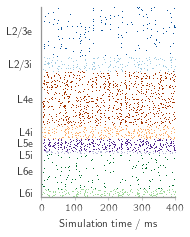

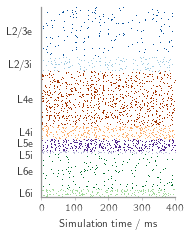

In [23]:
fig_names = ("raster_plot", "raster_plot_sli")

for sli, fig_name in zip([False, True], fig_names):
    fig = plt.figure()
    fig.set_size_inches(style.figsize[0]*0.5, style.figsize[1]) 
    ax = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    
    data_path = "/export/data-schuessler/data_microcircuit/micro"
    raster_sim_spec = "raster_plot"
    if sli:
        raster_sim_spec += "_sli"
    #raster_plot_results(sim_spec=raster_sim_spec, reverse_order=reverse_order) # produces results file
    res_file_name = raster_sim_spec + "_res.hdf5"
    path_res_file = os.path.join(data_path, res_file_name)

    plot_raster(ax, path_res_file)

    # General rendering
    style.fixticks(ax)
    ax.yaxis.set_ticks_position('none') 
    
    if save_fig:
        hf.saving_fig(fig, figure_path, fig_name)  

## Single neuron activity

In [6]:
def box_plot(ax, data, path_res_file, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)
    """Data has to be in the right order (will not be reversed)"""
    
    boxprops = dict(linewidth=0.5, color=style.text_color)
    flierprops  = dict(marker='+', markersize=style.cross_size*0.5,
                      linestyle='None', mew=0.5)
    medianprops = dict(color=style.text_color, linewidth=0.5)
    meanprops  = dict(marker='*', markersize=4, 
                      mec='0.95', #style.text_color, 
                      markerfacecolor='0.95', #style.text_color,
                      linestyle='None', mew=0.5)

    
    box = ax.boxplot(data,
                     vert=False, showfliers=True, showmeans=True,
                     boxprops=boxprops,
                     flierprops=flierprops, medianprops=medianprops,
                     meanprops=meanprops,
                     patch_artist=True)

    if reverse_order:
        box_colors = colors[::-1]
    else:
        box_colors = colors[:]        

    for i, population in enumerate(populations):
        box["boxes"][i].set_alpha(0.8)
        box["boxes"][i].set_facecolor(box_colors[i])
        #box["boxes"][i].set_color(box_colors[i])
        box["fliers"][i].set_color(box_colors[i])
        box["whiskers"][2*i].set_color(box_colors[i])
        box["whiskers"][2*i+1].set_color(box_colors[i])
        box["caps"][2*i].set_color(box_colors[i])
        box["caps"][2*i+1].set_color(box_colors[i])

    yticks = np.arange(n_types * 0.75, n_populations, n_types)
    yticklabels = hf.rlbl(layers)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ylim = (0, n_populations + 1.0)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylim(*ylim)   

In [7]:
def plot_single_rates(ax, path_res_file, n_spikes_recorded=1000, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

    single_rates = np.empty((n_populations, n_spikes_recorded))
    with h5py.File(path_res_file, "r") as res_file:
        res_grp = res_file["0/single_rates"]
        for i, population in enumerate(populations):
            if reverse_order:
                single_rates[-(i + 1)] = res_grp[population][:]
            else:
                single_rates[i] = res_grp[population][:]

    box_plot(ax, single_rates.T, path_res_file, reverse_order)
    
    ax.set_xlabel("Single neuron firing rates / Hz")

In [8]:
def plot_single_CV_ISI(ax, path_res_file, n_spikes_recorded=1000, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

    single_cv_isi = [[]] * n_populations
    with h5py.File(path_res_file, "r") as res_file:
        res_grp = res_file["0/single_cv_isi"]
        for i, population in enumerate(populations):
            if reverse_order:
                single_cv_isi[-(i + 1)] = res_grp[population][:]
                print(population, len(single_cv_isi[-(i + 1)]))
            else:
                single_cv_isi[i] = res_grp[population][:]
                print(population, len(single_cv_isi[i]))
    
    box_plot(ax, single_cv_isi, path_res_file, reverse_order)
    
    ax.set_xlabel("Irregularity")

/export/data-schuessler/data_microcircuit/micro/spon_act_statistic_res.hdf5
L23e 982
L23i 999
L4e 999
L4i 999
L5e 999
L5i 999
L6e 970
L6i 999
save figure to single_neuron_activity_rates
save figure to single_neuron_activity_irregularity


/usr/local/lib/python3.4/dist-packages/matplotlib/patches.py:102: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


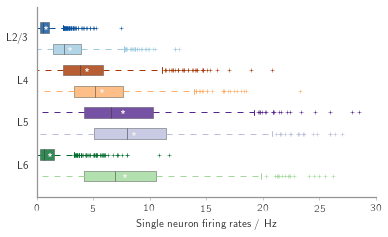

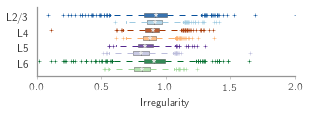

In [9]:
# DATA
data_path = "/export/data-schuessler/data_microcircuit/micro"
sim_spec = "spon_act_statistic"
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)
print(path_res_file)

fig_names = ("single_neuron_activity_rates", "single_neuron_activity_irregularity")

# Rates
fig1 = plt.figure()
fig1.set_size_inches(style.figsize[0], style.figsize[1])
ax1 = hf.add_subplot(fig1, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
plot_single_rates(ax1, path_res_file, n_spikes_recorded=1000)

# CV of interspike interval (ISI)
fig2 = plt.figure()
fig2.set_size_inches(style.figsize[0]*0.8, style.figsize[1]*0.5)
ax2 = hf.add_subplot(fig2, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
plot_single_CV_ISI(ax2, path_res_file, n_spikes_recorded=1000)
ax2.set_xlim(0, 2)
  
for fig, fig_name in zip((fig1, fig2), fig_names):
    for ax in fig.axes:
        style.fixticks(ax)   
        ax.yaxis.set_ticks_position('none') 
    if save_fig:
        hf.saving_fig(fig, figure_path, fig_name)  

# Plot single membrane potential

In [8]:
def solve_model(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               jacobian=False, root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root

    if jacobian==False:
        jac = False
    else:
        print("Use jacobian")
        jac = model.jacobian
        
    # Run on initial guess v_guess_0
    sol = root(model.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    if sol["success"]:
        v0  = sol["x"]
        if np.all(v0 < 1./model.t_ref): 
            return v0
        else:       # converged unphysically (v0 >= 1/t_ref)
            raise Exception("Converged unphysically for v_guess_0")
    else:   
        raise Exception("No solution found for v_guess_0")
        

In [9]:
def prob_V(V_array, mu_i, sd_i, v0_i, model=model_class.model()):
    """Membrane potential probability distribution P(V_m) according to Brunel"""
    from scipy.integrate import quad
    step        = lambda x: 0.5 * (np.sign(x) + 1)  # Heaviside step function
    red         = lambda V: (V - mu_i) / sd_i           # reduced voltage
    P_integrand = lambda u: step(u - red(model.V_r)) * np.exp(u**2) # integrand
    
    Vs = V_array - model.E_L # shift since Brunel's model is using E_L = 0
    
    # Integral boundaries
    lowers  = red(Vs)
    upper  = red(model.theta)
  
    integrals   = np.array([quad(P_integrand, lower, upper)[0] for lower in lowers])

    P_V_array   = 2 * v0_i * model.tau_m / sd_i * np.exp(- (Vs - mu_i)**2 / sd_i**2) * integrals
    
    return step(-Vs + model.theta) * P_V_array

In [10]:
def plot_membrane_potential_single(path_res_file, rate_mf, figname):
    # Model
    connection_rule = "fixed_indegree"
    weight_rel_sd   = 0.1 # 0.1 for micro
    model           = model_class.model(connection_rule=connection_rule,
                                               weight_rel_sd=weight_rel_sd) 

    # Get voltage data
    with h5py.File(path_res_file, "r") as res_file:
        sim_spec2 = "0"
        res_grp = res_file[sim_spec2]
        # Rates
        rates_mean   = res_grp["rates_mean"][:]
        rates_std    = res_grp["rates_std"][:]
        # Voltage
        dset_times_volt     = res_grp["times_volt"]
        t_min_volt = dset_times_volt.attrs["t_min_volt"]
        t_max_volt = dset_times_volt.attrs["t_max_volt"]
        dt_volt    = dset_times_volt.attrs["dt_volt"]
        volt_histo_means  = res_grp["volt_histo_means"][:]
        V_min       = res_grp.attrs["V_min"]
        V_max       = res_grp.attrs["V_max"]
        n_bins_volt = res_grp.attrs["n_bins_volt"]
        n_neurons_rec_voltage = res_grp.attrs["n_neurons_rec_voltage"][:]

    # Input according to Brunel
    mu_brunel   = model.mu(rate_mf)
    sd_brunel   = model.sd(rate_mf)
    # and with simulated input
    mu_sim      = model.mu(rates_mean)
    sd_sim      = model.sd(rates_mean)
    
    # Voltage: Index of V = E_L
    V_step = (V_max - V_min) / n_bins_volt
    V_array = np.arange(V_min, V_max, V_step)
    V_r_arg = np.argmin(np.abs(V_array - (model.V_r + model.E_L))) # Index of neurons in refractory period
    n_t = (t_max_volt - t_min_volt) / dt_volt # number of time bins
    V_range_plot = [-80, V_max + 1]

    # Figure
    fig = plt.figure()
    fig.set_size_inches(style.figsize[0], style.figsize[1]) 
    ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    
    i = 4
    population = populations[i]

    # Remove neurons in refractory period
    with h5py.File(path_res_file, "r") as res_file:
        single_rates = res_file["0/single_rates/" + population][:n_neurons_rec_voltage[i]]
    P_V_data =  volt_histo_means[i].copy()
    P_V_data[V_r_arg] -= np.sum(single_rates) * model.t_ref * n_t

    # Normalization
    norm_factor = n_t * n_neurons_rec_voltage[i] * V_step
    P_V_data_normed = P_V_data / norm_factor

    # Theoretical distirbution using Brunel's mu and sd but measured rate v0
    P_V_theo = prob_V(V_array, mu_brunel[i], sd_brunel[i], rate_mf[i], model=model)

    # Adjust histogram for "steps"
    P_V_data_normed = hf.adjust_steps(P_V_data_normed)

    # Plotting
    ymax = 0.17 # max height for each population
    # Labels
    marker_sim = "-"
    marker_mf  = "-"
    ax1.plot(V_array, P_V_data_normed, 
             marker_sim, linewidth=1.5, color=colors[i], drawstyle="steps")
    ax1.plot(V_array, P_V_theo, marker_mf, linewidth=1.5, color=colors[i], label=hf.rlbl(population))

        
    # Resting potential and treshhold
    ax1.plot([model.E_L + model.theta]*2, [0, n_populations * ymax], 
             "--", linewidth=1.5, color="darkgray", zorder=0 )#, label="$\\theta$")
    ax1.plot([model.E_L]*2, [0, n_populations * ymax], 
             "-.", linewidth=1.5, color="darkgray", alpha=0.5, zorder=0 )#, label="$E_L$")
    
    # Axes label, etc.
    ax1.set_xlabel('Membrane potential $V_m$ / mV')
    ax1.set_ylabel('Probability $P(V)$')
    ax1.set_ylim(0, ymax)
    ax1.set_xlim(*V_range_plot)
    ax1.grid(False)
    ax1.legend(loc='best')

    for ax in fig.axes:
        style.fixticks(ax)
        
    if save_fig:
        hf.saving_fig(fig, figure_path, figname, verbose=True)  

save figure to results_membrane_single


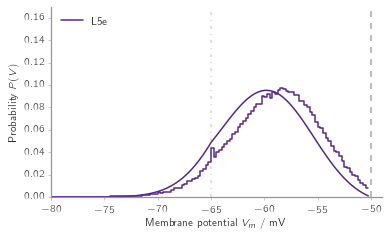

In [11]:
sim_spec = "membrane_potential"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

plot_membrane_potential_single(path_res_file, rate_mf, figname="results_membrane_single")